In [8]:
%matplotlib inline

In [97]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from cv2 import VideoWriter, VideoWriter_fourcc
import pandas as pd
import torch
from scipy import signal, ndimage, spatial
from scipy.signal import correlate
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter
import math 
#from signal_alignment import phase_align, chisqr_align
from scipy.interpolate import interp1d
import scipy.stats as stats
from scipy.stats import spearmanr

# Purpose of this page

1. read the finetuned fan landmarks for the BBP and OPEN task of HC and ALS participants of neuroFace dataset
2. calculate the mouth opening for each 
3. calculate the repetitions per task using scipy fuction signal.find_peaks

### Function Definitions 

In [79]:


def vlipDist(DF):
    
    # Assumes columns are named in a particular way 
    DF = DF.astype({ "landmark_51": np.double, "landmark_51.1": np.double,"landmark_51.2": np.double, 
                      "landmark_57": np.double,  "landmark_57.1": np.double,  "landmark_57.2": np.double})
    
    DF['Vert_Lip_Motion'] = DF.apply(lambda row: math.sqrt((row.landmark_51 - row.landmark_57)**2 + 
                                                     (row['landmark_51.1'] - row['landmark_57.1'])**2 +
                                                    (row['landmark_51.2'] - row['landmark_57.2'])**2), axis = 1)
    return np.array(DF['Vert_Lip_Motion'].values)



### Reading NeuroFace ALS and HC open and bbp data if available 

In [23]:
pop = ['ALS', 'Healthy_Control']

Tasks = ['OPEN', 'BBP']

ALS = ['AF02_SBK_20170517', 'AF06_SBK_20170530', 'AF08_SBK_20170606','AF09_SBK_20170613', 'AF10_SBK_20170613',
       'AF11_SBK_20170928','AF12_SBK_20180731', 'AF14_SBK_20190129', 'AF15_SBK_20190402', 'AF16_SBK_20190403',
       'AF17_SBK_20190416']

HC = ['NF01_SBK_20170515', 'NF02_SBK_20170517', 'NF03_TRI_20170518', 'NF04_TRI_20170524', 'NF07_SBK_20170530',
      'NF08_SBK_20170615', 'NF10_SBK_20180212', 'NF11_SBK_20180730', 'NF12_TRI_20190321', 'NF17_TRI_20190613',
      'NF19_TRI_20190627']

TASK_DFS_VIDEO_LIST = list()

root = '/media/deniz/easystore/facial_tracking_data_2021/'

sub_folders = '/02/LANDMARKS/Diego_FaceData/landmarks_finetuned_w15'

a_extension = '_landmarksFiltered3D.csv'


In [32]:
bbp_csvs = []
open_csvs = []

    
for p in pop:
    p_path = os.path.join(root, p)
    if p == 'ALS':
        for a in ALS:
            try:
                path = os.path.join(p_path, a) + sub_folders
                list_pop_tracking_data = os.listdir(path)
                bbp = [os.path.join(path, i) for i in list_pop_tracking_data if (i.endswith(a_extension)) and ("BBP" in i)]
                nsm_open = [os.path.join(path, i) for i in list_pop_tracking_data if (i.endswith(a_extension)) and ("OPEN" in i)]
                print(path, len(bbp), len(nsm_open))

                bbp_csvs += bbp

                open_csvs += nsm_open
            except:
                print(path, ": doesn't exist")
                pass
    else:
        for h in HC:
            try:
                path = os.path.join(p_path, h) + sub_folders
                list_pop_tracking_data = os.listdir(path)
                bbp = [os.path.join(path, i) for i in list_pop_tracking_data if (i.endswith(a_extension)) and ("BBP" in i)]
                nsm_open = [os.path.join(path, i) for i in list_pop_tracking_data if (i.endswith(a_extension)) and ("OPEN" in i)]
                print(path, len(bbp), len(nsm_open))

                bbp_csvs += bbp

                open_csvs += nsm_open
            except:
                print(path, ": doesn't exist")
                pass
            

        

/media/deniz/easystore/facial_tracking_data_2021/ALS/AF02_SBK_20170517/02/LANDMARKS/Diego_FaceData/landmarks_finetuned_w15 : doesn't exist
/media/deniz/easystore/facial_tracking_data_2021/ALS/AF06_SBK_20170530/02/LANDMARKS/Diego_FaceData/landmarks_finetuned_w15 1 1
/media/deniz/easystore/facial_tracking_data_2021/ALS/AF08_SBK_20170606/02/LANDMARKS/Diego_FaceData/landmarks_finetuned_w15 1 1
/media/deniz/easystore/facial_tracking_data_2021/ALS/AF09_SBK_20170613/02/LANDMARKS/Diego_FaceData/landmarks_finetuned_w15 1 1
/media/deniz/easystore/facial_tracking_data_2021/ALS/AF10_SBK_20170613/02/LANDMARKS/Diego_FaceData/landmarks_finetuned_w15 1 1
/media/deniz/easystore/facial_tracking_data_2021/ALS/AF11_SBK_20170928/02/LANDMARKS/Diego_FaceData/landmarks_finetuned_w15 1 1
/media/deniz/easystore/facial_tracking_data_2021/ALS/AF12_SBK_20180731/02/LANDMARKS/Diego_FaceData/landmarks_finetuned_w15 : doesn't exist
/media/deniz/easystore/facial_tracking_data_2021/ALS/AF14_SBK_20190129/02/LANDMARKS/Die

In [33]:
# TOTAL NUMBER OF FILES WE HAVE FINE TUNED FAN 3D LANDMARKS EXTRACTED FOR PREVIOUSLY 
print(len(bbp_csvs), len(open_csvs))

18 18


In [80]:
# GET THE VERTICAL MOUTH OPENING ARRAYS 

bbp_rom = []
open_rom = []

for b in bbp_csvs:
    df = pd.read_csv(b)
    
    df = df.drop(df.index[0])
    v_rom = vlipDist(df)
    bbp_rom.append(v_rom)
    

for b in open_csvs:
    df = pd.read_csv(b)
    df = df.drop(df.index[0]) 
    
    v_rom = vlipDist(df)
    open_rom.append(v_rom)
    
print(len(bbp_rom), len(open_rom))





18 18


array([15.79645909, 16.2753118 , 16.00484089, ...,         nan,
               nan,         nan])

In [91]:
# REPORT AND THEN DROP THE NANs
for b in bbp_rom:
    if np.isnan(b).any():
        print(bbp_rom.index(b))
        i = bbp_rom.index(b)
        b = b[~np.isnan(b)]
        bbp_rom[i]= b
        
for b in open_rom:
    if np.isnan(b).any():
        print('open', open_rom.index(b))
        i = open_rom.index(b)
        b = b[~np.isnan(b)]
        open_rom[i]= b
        

0
open 0
open 6


/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/ipykernel/__main__.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/ipykernel/__main__.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [94]:
# MAKE SURE NAN ENTRIES ARE REMOVED
print(np.isnan(bbp_rom[0]).any())
print(np.isnan(open_rom[0]).any())
print(np.isnan(open_rom[6]).any())

False
False
False


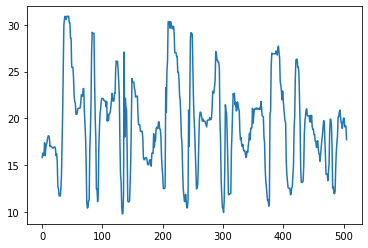

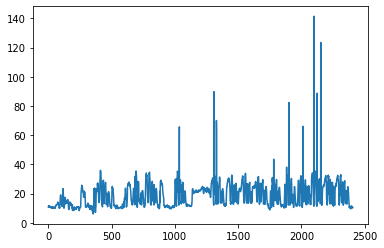

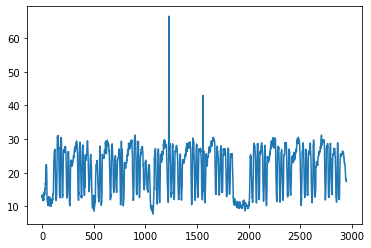

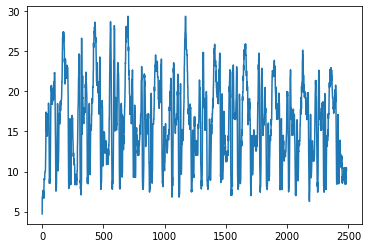

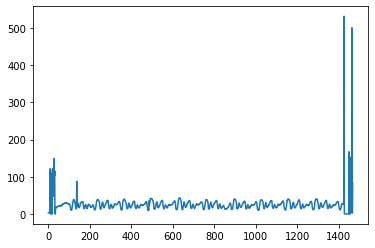

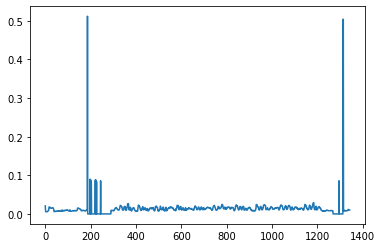

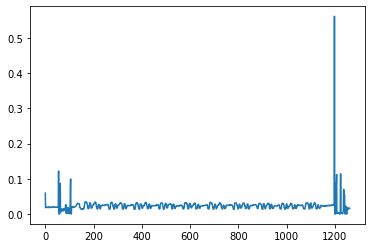

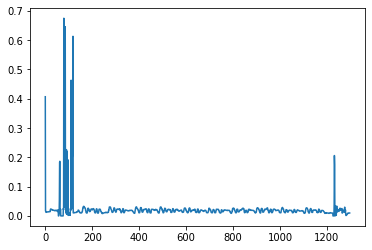

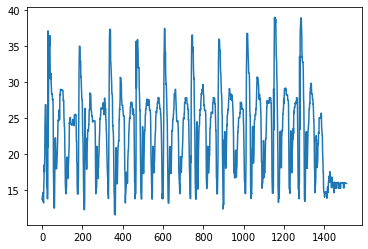

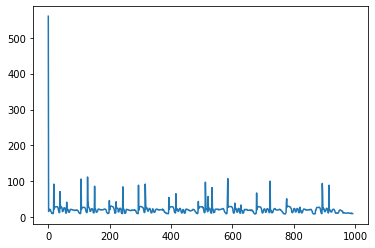

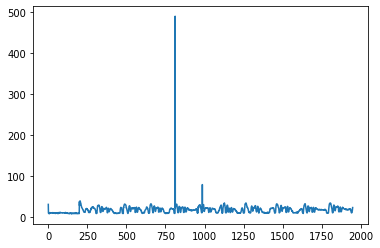

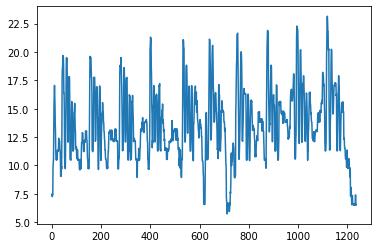

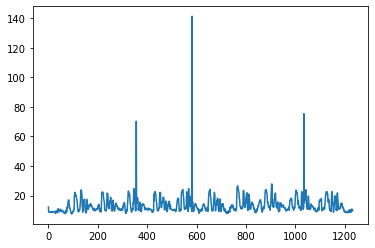

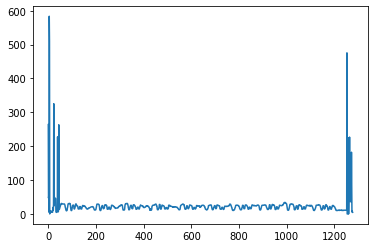

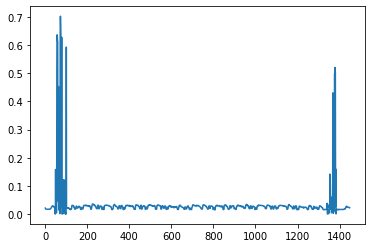

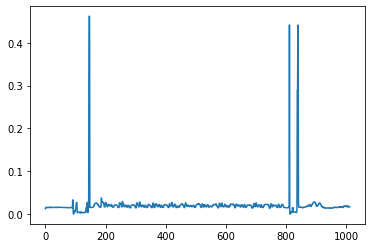

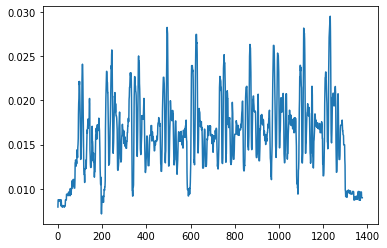

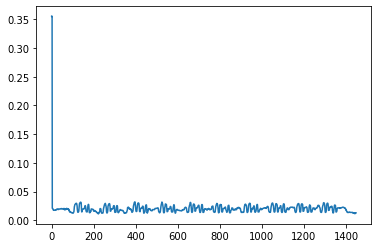

In [95]:
for i in bbp_rom:
    plt.figure()
    plt.plot(i)

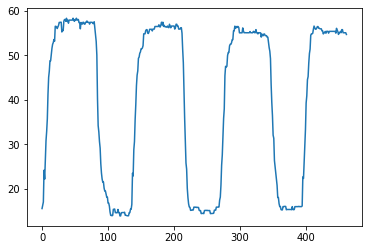

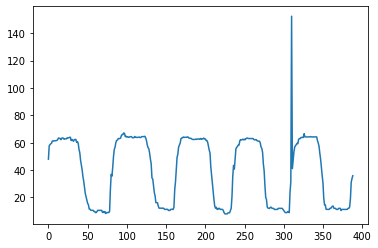

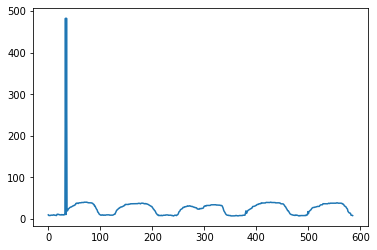

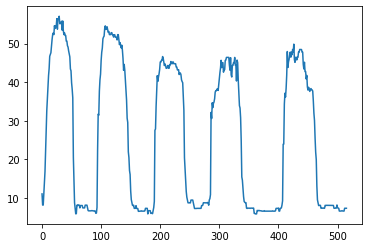

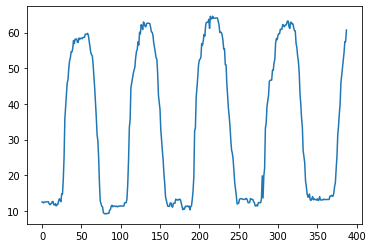

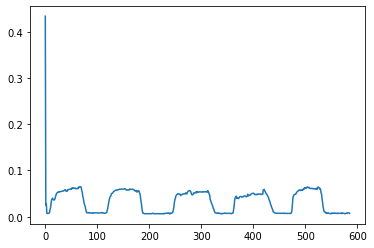

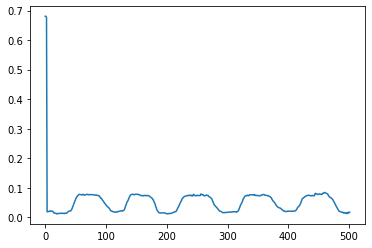

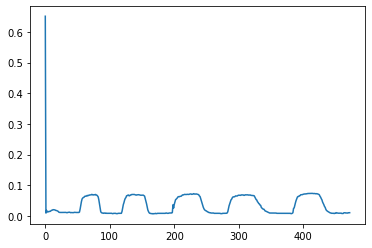

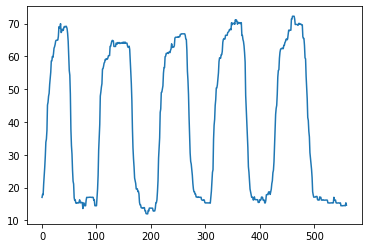

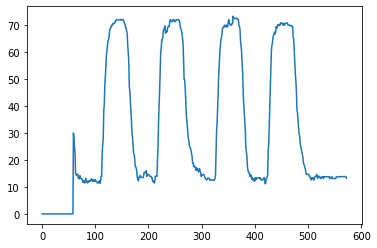

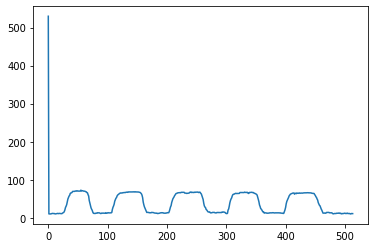

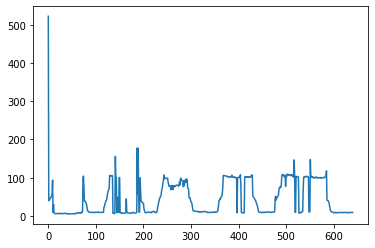

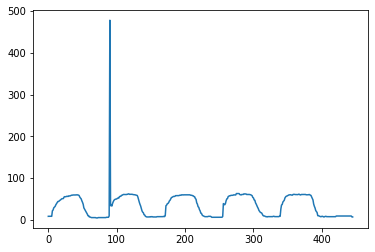

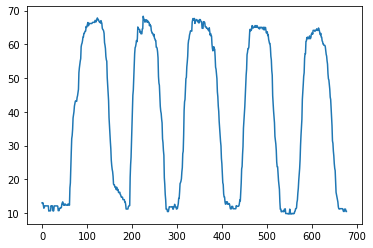

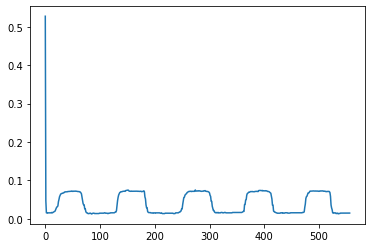

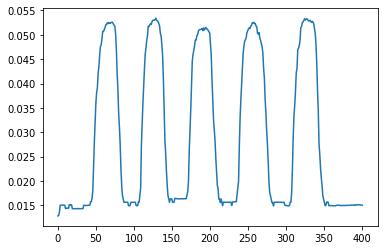

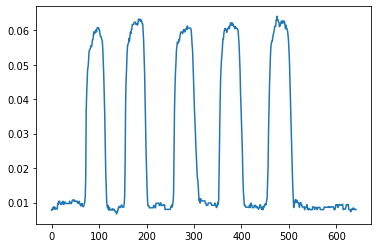

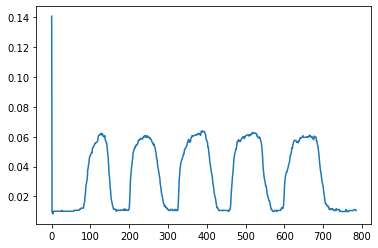

In [96]:
for i in open_rom:
    plt.figure()
    plt.plot(i)

In [98]:
# STORE A COPY OF ORIGINAL 

bbp_rom_org = bbp_rom
open_rom_org = open_rom

## DATA CLEANING

1. get rid of the spikes at the begining and end of the arrays
2. use mid filter to smooth out the signals

In [100]:

#Apply median filter to get rid of the outliers

for i in range(len(bbp_rom)):
    bbp_rom[i] = signal.medfilt(bbp_rom[i], kernel_size=5)
    
    
for i in range(len(open_rom)):
    open_rom[i] = signal.medfilt(open_rom[i], kernel_size=5)
       
        

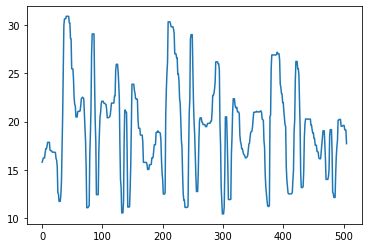

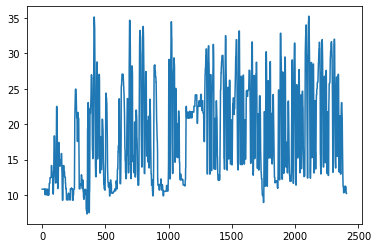

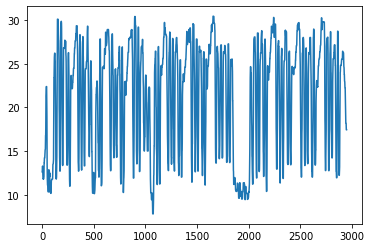

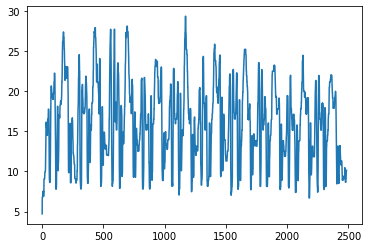

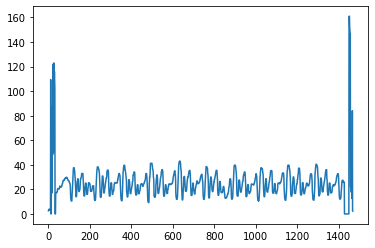

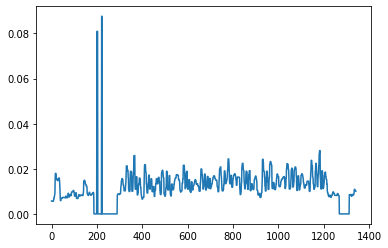

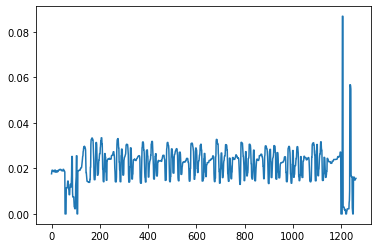

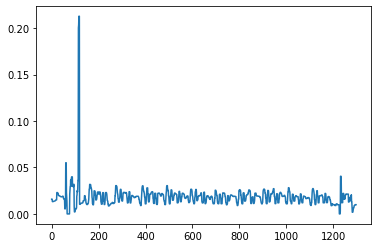

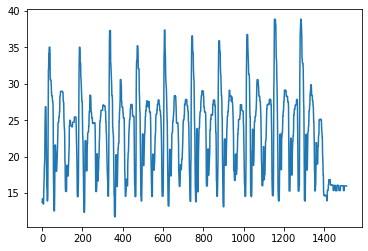

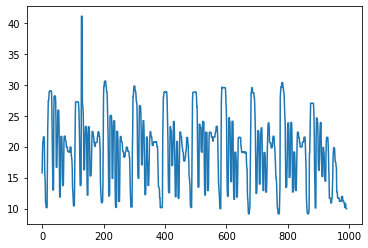

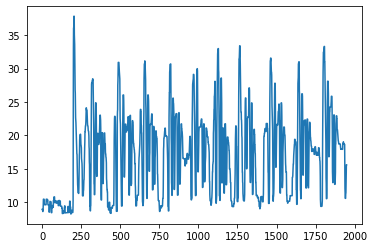

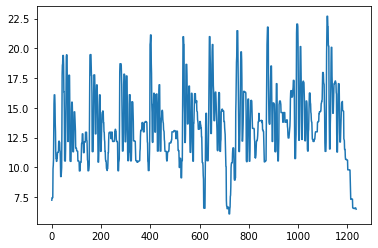

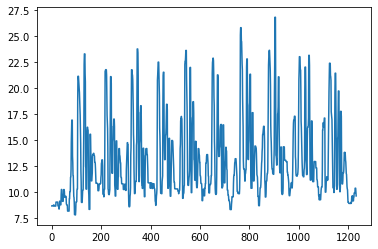

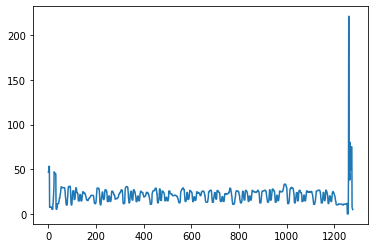

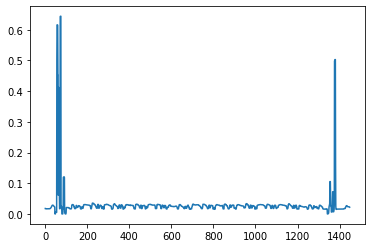

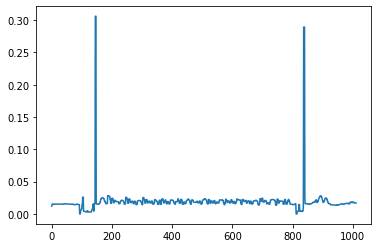

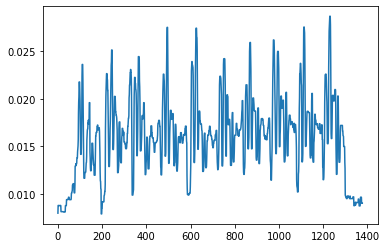

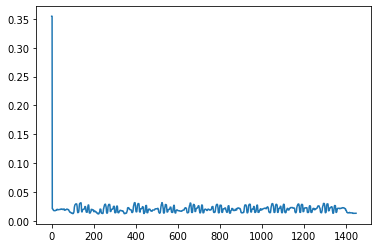

In [101]:
for i in bbp_rom:
    plt.figure()
    plt.plot(i)

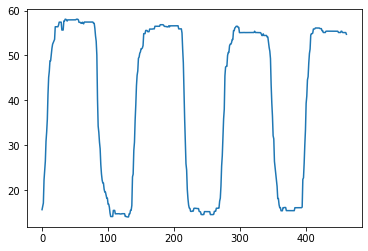

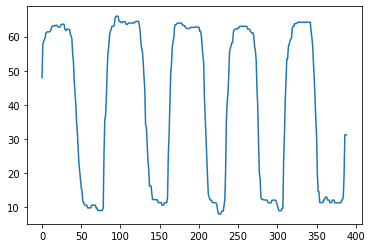

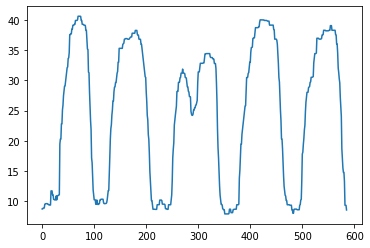

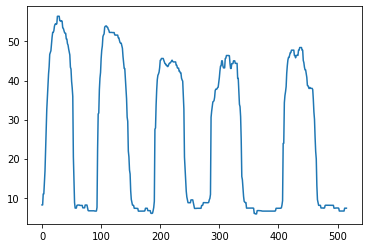

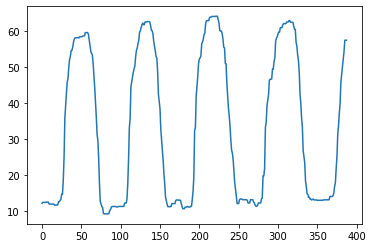

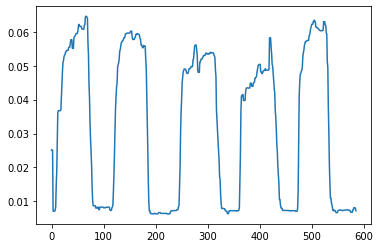

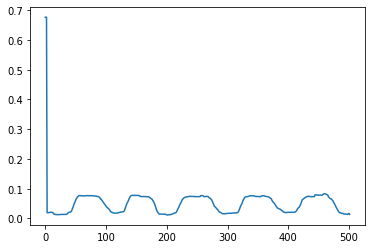

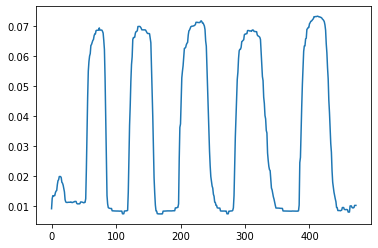

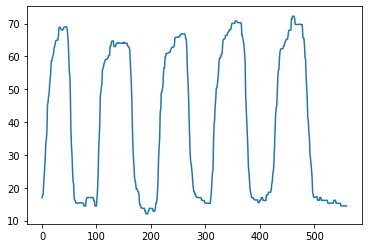

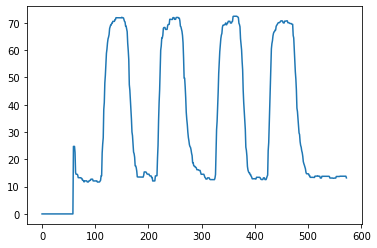

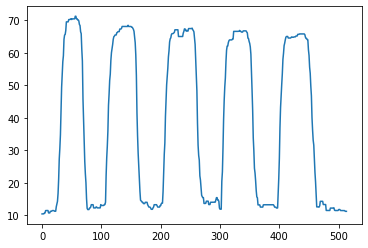

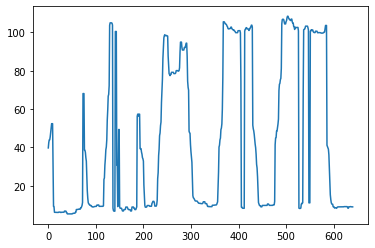

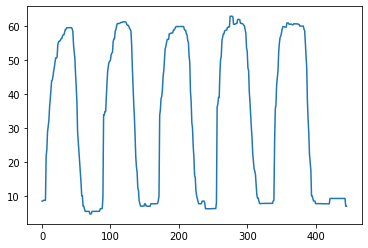

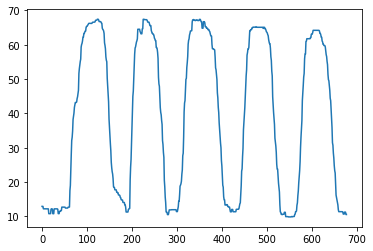

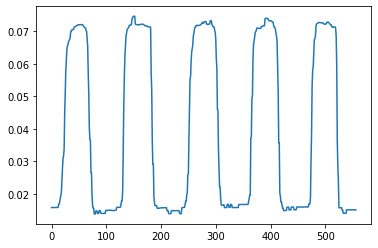

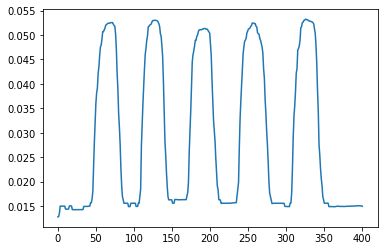

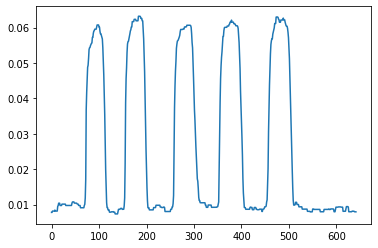

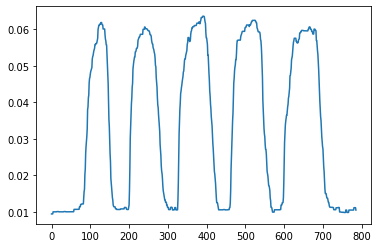

In [102]:
for i in open_rom:
    plt.figure()
    plt.plot(i)

In [110]:
# GET RID OF THE OUTLIERS

for i in range(len(bbp_rom)):
    print(i, len(bbp_rom[i]))
    z_scores = stats.zscore(bbp_rom[i])
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3)
    bbp_rom[i] = bbp_rom[i][filtered_entries]
    print(len(bbp_rom[i]))
    
    
for i in range(len(open_rom)):
    print(i, len(open_rom[i]))
    z_scores = stats.zscore(open_rom[i])
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3)
    open_rom[i] = open_rom[i][filtered_entries]
    print(len(open_rom[i]))
    
    


0 506
506
1 2407
2407
2 2947
2947
3 2485
2485
4 1468
1449
5 1343
1337
6 1262
1254
7 1298
1293
8 1512
1512
9 993
990
10 1949
1946
11 1237
1237
12 1234
1228
13 1278
1268
14 1449
1431
15 1012
1005
16 1378
1378
17 1449
1446
0 462
462
1 389
389
2 586
586
3 516
516
4 388
388
5 586
586
6 502
499
7 473
473
8 560
560
9 573
573
10 514
514
11 641
641
12 446
446
13 678
678
14 557
557
15 402
402
16 642
642
17 786
786


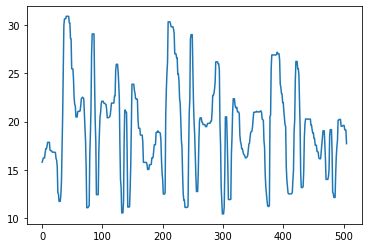

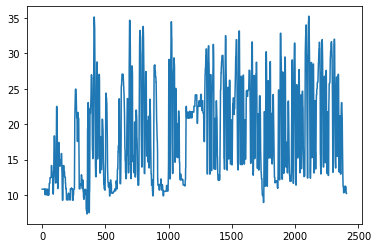

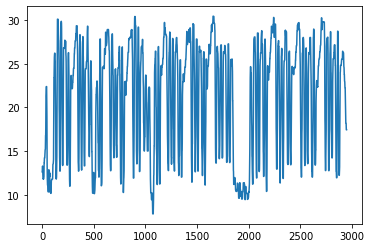

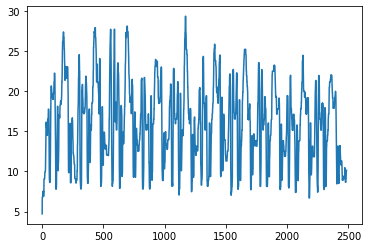

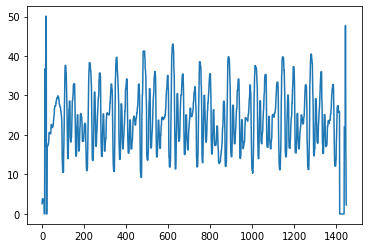

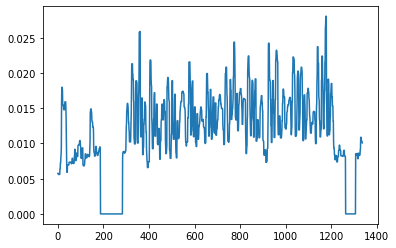

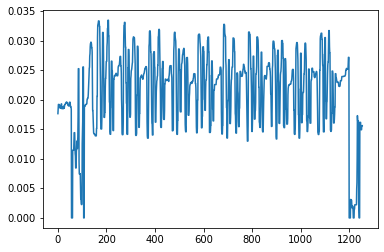

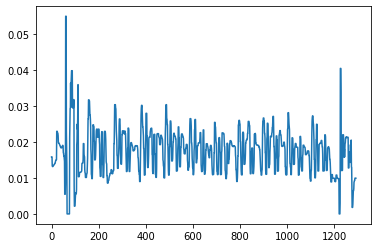

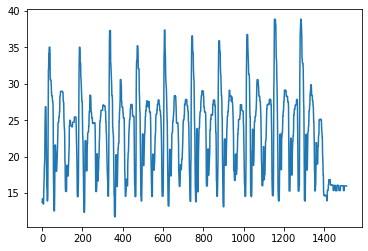

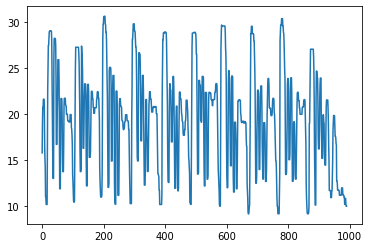

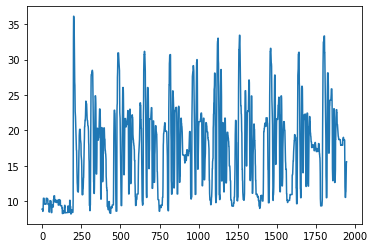

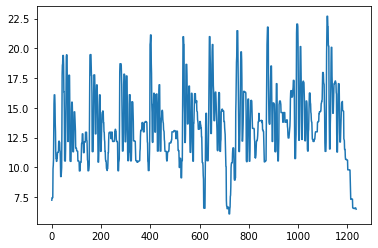

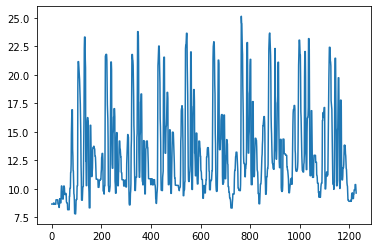

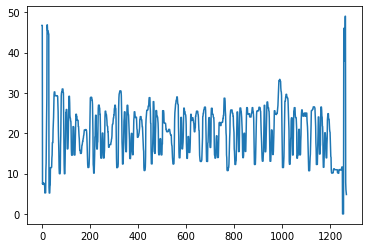

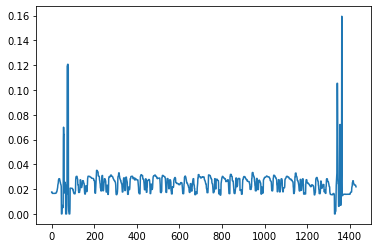

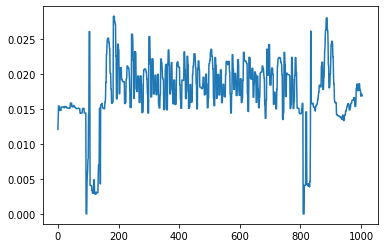

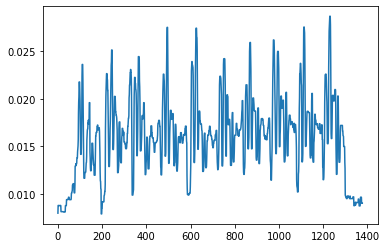

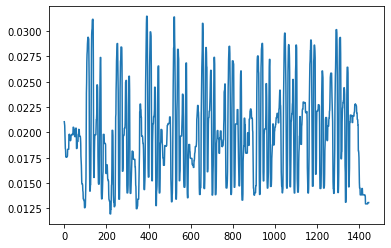

In [111]:
for i in bbp_rom:
    plt.figure()
    plt.plot(i)

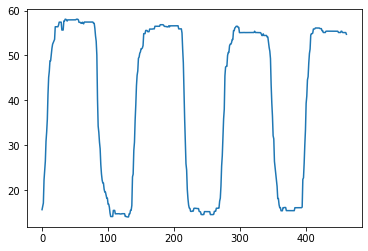

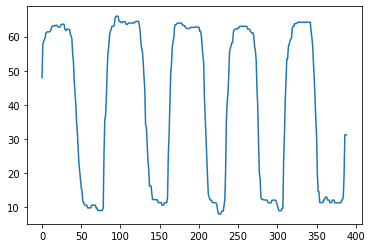

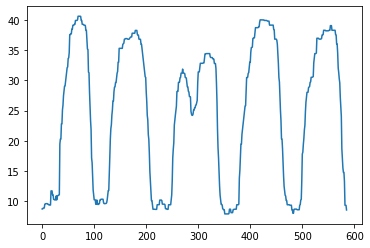

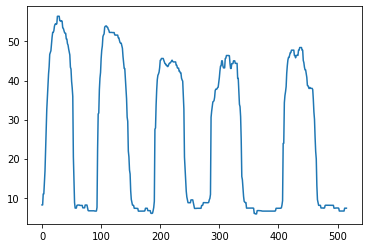

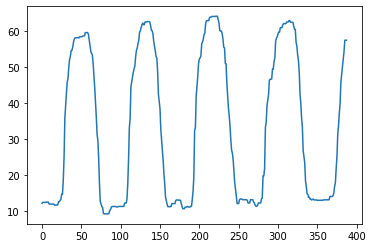

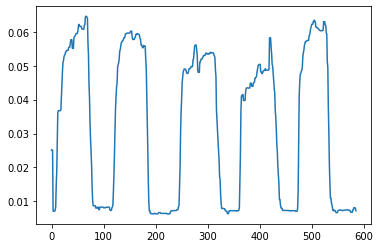

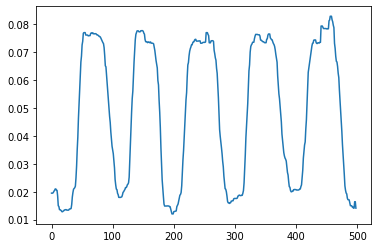

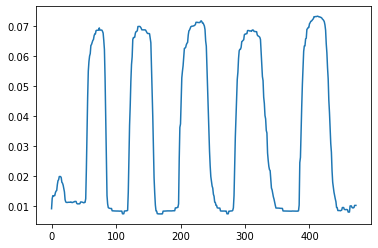

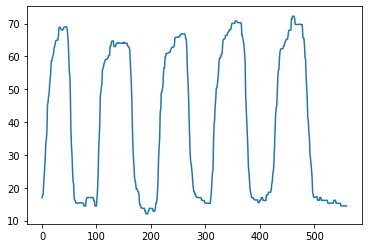

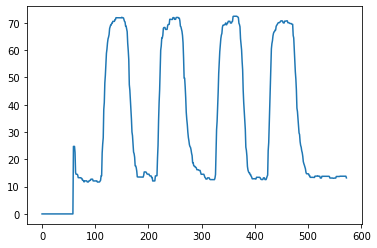

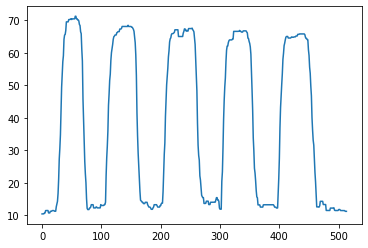

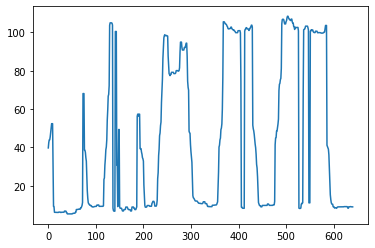

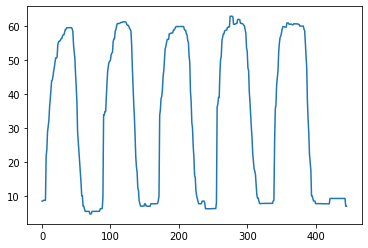

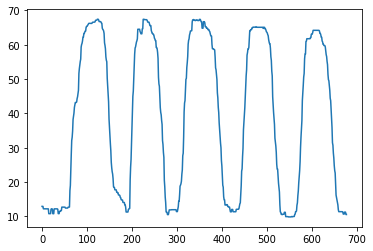

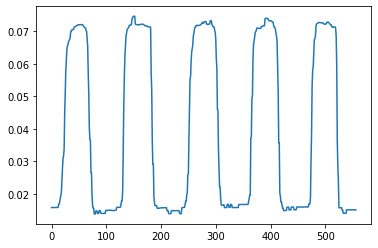

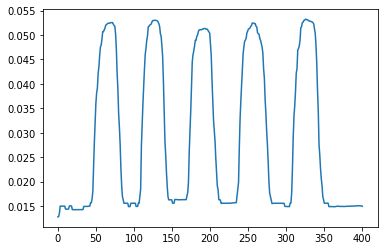

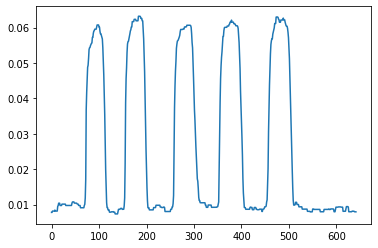

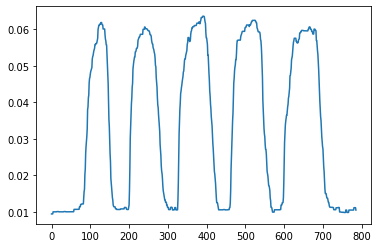

In [112]:
for i in open_rom:
    plt.figure()
    plt.plot(i)

In [129]:
# Find the number of peaks

# two values are needed 
# height for the threshold which I use the average value of max and mean value of each array for now 
# for the distance I will use the len of the array divided by the number of reps 

def average(number1, number2):
  return (number1 + number2) / 2

open_rep = 5
bbp_rep = 10


for i in open_rom:
    height = average(i.mean(),i.max())
    distance = len(i)/open_rep
    peaks, _ = signal.find_peaks(i, height= height, distance= distance)
    try: 
        print(open_rom.index(i), len(peaks), 'The peaks are: ', peaks)
        print()
    except: 
        print(peaks)
    
for i in bbp_rom:
    height = average(i.mean(),i.max())
    distance = len(i)/bbp_rep
    peaks, _ = signal.find_peaks(i, height= height, distance= distance)
    print(bbp_rom.index(i),len(peaks), 'The peaks are: ', peaks)
    print()

0 4 The peaks are:  [ 53 181 295 416]

1 4 The peaks are:  [ 95 175 256 337]

2 3 The peaks are:  [ 71 421 555]

3 4 The peaks are:  [ 28 203 314 437]

4 4 The peaks are:  [ 56 135 222 314]

[ 66 277 505]
6 4 The peaks are:  [148 254 356 457]

7 3 The peaks are:  [136 232 412]

8 3 The peaks are:  [ 43 259 461]

9 2 The peaks are:  [150 363]

10 3 The peaks are:  [ 56 253 437]

11 3 The peaks are:  [131 369 503]

12 3 The peaks are:  [120 276 368]

13 3 The peaks are:  [124 351 493]

14 4 The peaks are:  [151 276 392 504]

15 2 The peaks are:  [127 326]

16 2 The peaks are:  [184 475]

17 3 The peaks are:  [129 391 665]

0 5 The peaks are:  [ 40 124 210 289 390]

1 7 The peaks are:  [ 411  692 1021 1315 1558 1803 2108]

2 7 The peaks are:  [ 151  561  898 1235 1656 2241 2704]

3 6 The peaks are:  [ 174  432  693 1170 1658 2128]

4 6 The peaks are:  [  19  355  622  887 1280 1443]

5 5 The peaks are:  [ 360  578  774  925 1177]

6 6 The peaks are:  [ 207  416  684  820  984 1116]

7 2 T

/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/ipykernel/__main__.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/deniz/.pyenv/versions/reqtxt/lib/python3.6/site-packages/ipykernel/__main__.py:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
